<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/TimeSeries_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#### Dataset Context
> This dataset contains temporal data from a Wireless Sensor Network deployed in real-world office environments. The task is intended as real-life benchmark in the area of Ambient Assisted Living 

from: [ics.edu/ml](https://archive.ics.uci.edu/ml/datasets/Indoor+User+Movement+Prediction+from+RSS+data)



> Our dataset comprises of 316 files:

- 314 MovementAAL csv files containing the readings from motion sensors placed in the environment
- A `Target.csv`  contains the target variable for each MovementAAL file
- `DatasetGroup.csv` identify which MovementAAL file belongs to which setup group, which can be use to split data into **train, test and validation sets**
- The `Path.csv` contains the path which the object took


In [550]:
!unzip -q MovementAAL.zip

replace dataset/MovementAAL_RSS_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [551]:
import pandas as pd

Each `MovementAAL_RSS.csv` contain normalized data from the four sensors – A1, A2, A3, A4. The length of the csv files (number of rows) vary, since the data corresponding to each csv is for a different duration. **We will suppose the sensor data is collected every second**

In [552]:
path = '/content/dataset/MovementAAL_RSS_'
sequences = list()
for i in range(1, 315):
    file_path = f'{path}{str(i)}.csv'
    # print(file_path)
    df = pd.read_csv(file_path, header=0, dtype='float32')
    values = df.values
    sequences.append(values)

In [553]:
len(sequences)

314

Load in the `target.csv` file and select the clasification labels

In [554]:
targets_csv = '/content/dataset/MovementAAL_target.csv'
targets = pd.read_csv(targets_csv, dtype='float32')
targets.head()

,#sequence_ID,class_label
0,1.0,1.0
1,2.0,1.0
2,3.0,1.0
3,4.0,1.0
4,5.0,1.0


In [555]:
targets = targets.values[:,1]
targets[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

Load in the `DatasetGroup.csv` file and select `dataset_ID`

In [556]:
group_csv = '/content/groups/MovementAAL_DatasetGroup.csv'
groups = pd.read_csv(group_csv, header=0)
groups = groups.values[:,1]
groups[:10], len(groups)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 314)

### 2. Data Visualization

In [557]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [558]:
sns.set_palette('vlag')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1
plt.rc('figure', titlesize = 16)

In [559]:
pd.DataFrame(sequences[0]).head()

,0,1,2,3
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


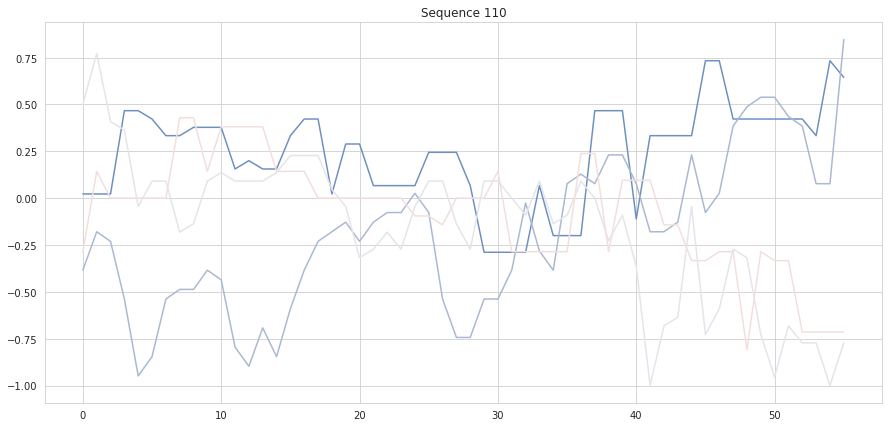

In [746]:
idx = np.random.randint(0, len(sequences))
plt.title(f'Sequence {idx}')
plt.plot(sequences[idx]);

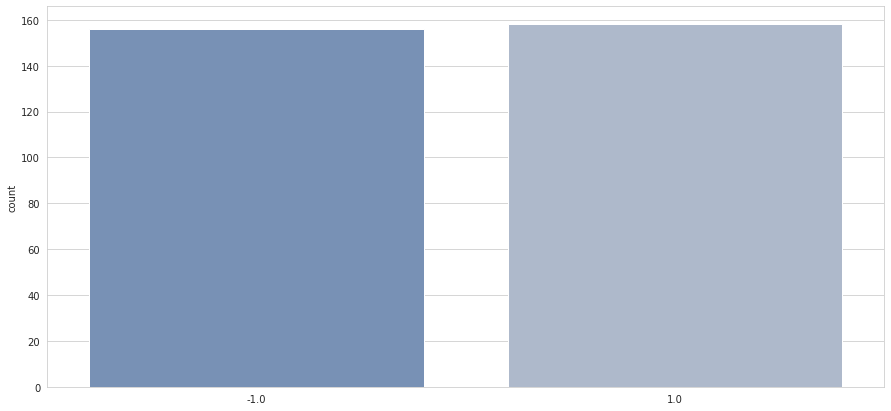

In [561]:
sns.countplot(x=targets)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


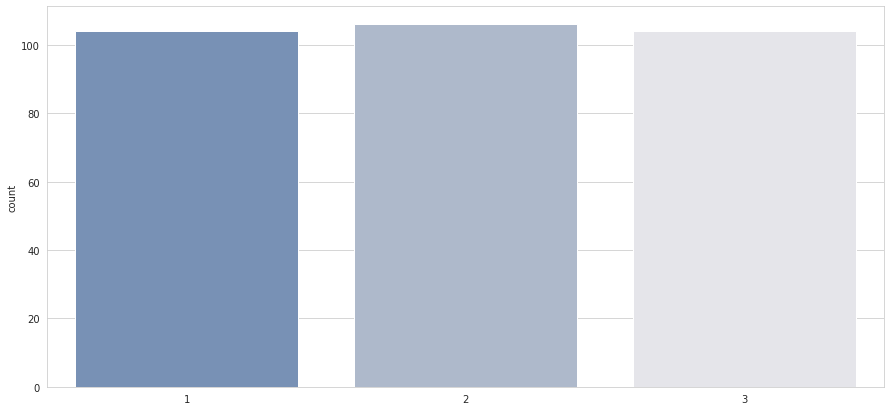

In [562]:
sns.countplot(x=groups)

### 3. Preprocessing

In [614]:
import numpy as np

#### 3.1 Padding

In [615]:
seqs_length = []
for sequence in sequences:
    seqs_length.append(len(sequence))
pd.Series(seqs_length).describe()

count    314.000000
mean      42.028662
std       16.185303
min       19.000000
25%       26.000000
50%       41.000000
75%       56.000000
max      129.000000
dtype: float64

Most files are between 40 to 60, 3 files habe length more than 100. The 90th quartile is 60 and should be taken as the sequence length

> Padding the sequence with the values in last row to max length

In [616]:
to_pad = 129
new_seqs = []
for sequence in sequences:
    seq_len = len(sequence)
    last_val = sequence[-1]
    n = to_pad - seq_len
   
    to_concat = np.repeat(sequence[-1], n).reshape(4, n).transpose()
    new_seq = np.concatenate([sequence, to_concat])
    new_seqs.append(new_seq)

final_seq = np.stack(new_seqs)

# truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = 60
final_seq = sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

#### 3.2 Data Splitting
> Split data into `train, validation, test` set based on groups

In [617]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []

for i in range(len(groups)):
  if groups[i] == 1:
    X_val.append(final_seq[i])
    y_val.append(targets[i])

  elif groups[i] == 2:
    X_train.append(final_seq[i])
    y_train.append(targets[i])

  elif groups[i] == 3:
    X_test.append(final_seq[i])
    y_test.append(targets[i])

X_train, y_train = np.array(X_train), (np.array(y_train) + 1) / 2
X_test, y_test = np.array(X_test), (np.array(y_test) + 1) / 2
X_val, y_val = np.array(X_val), (np.array(y_val) + 1) / 2

X_train.shape, y_train.shape

((106, 60, 4), (106,))

#### 3.3 Normalized Data

In [618]:
from sklearn.preprocessing import normalize

In [619]:
X_train = np.array([normalize(X) for X in X_train])
X_test = np.array([normalize(X) for X in X_test])
X_val = np.array([normalize(X) for X in X_val])

### 4. Model

In [569]:
! pip install scikit-plot --quiet

In [570]:
from sklearn.metrics import classification_report

import scikitplot

In [571]:
def visualize_performance(history, metric):
  plt.title(f'Model {metric}')
  plt.plot(history[metric])
  plt.plot(history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train_' + metric, 'val_' + metric])
  plt.title(f'Model {metric}')

#### 4.1 LSTM Neural Network - TensorFlow

In [713]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
print(tf.__version__)

In [727]:
def build_model(input_shape):
  model = keras.Sequential()
  model.add(layers.LSTM(256, input_shape=input_shape, return_sequences=True))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(128))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

In [728]:
input_shape = (X_train.shape[1], X_train.shape[2])
LSTM_model = build_model(input_shape)

lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.BinaryCrossentropy()
metric = ['accuracy']
LSTM_model.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [729]:
epochs = 10
batch_size = 32
history = LSTM_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
4/4 [==============================] - 6s 648ms/step - loss: 0.7129 - accuracy: 0.6132 - val_loss: 0.6799 - val_accuracy: 0.6058
Epoch 2/10
4/4 [==============================] - 1s 380ms/step - loss: 0.5205 - accuracy: 0.7453 - val_loss: 0.6738 - val_accuracy: 0.5865
Epoch 3/10
4/4 [==============================] - 1s 386ms/step - loss: 0.4462 - accuracy: 0.7642 - val_loss: 0.6652 - val_accuracy: 0.6442
Epoch 4/10
4/4 [==============================] - 1s 382ms/step - loss: 0.3340 - accuracy: 0.8679 - val_loss: 0.6621 - val_accuracy: 0.6827
Epoch 5/10
4/4 [==============================] - 1s 389ms/step - loss: 0.2618 - accuracy: 0.8679 - val_loss: 0.6599 - val_accuracy: 0.6731
Epoch 6/10
4/4 [==============================] - 1s 388ms/step - loss: 0.2403 - accuracy: 0.8868 - val_loss: 0.6587 - val_accuracy: 0.6250
Epoch 7/10
4/4 [==============================] - 1s 378ms/step - loss: 0.2463 - accuracy: 0.9057 - val_loss: 0.6423 - val_accuracy: 0.6827
Epoch 8/10
4/4 [====

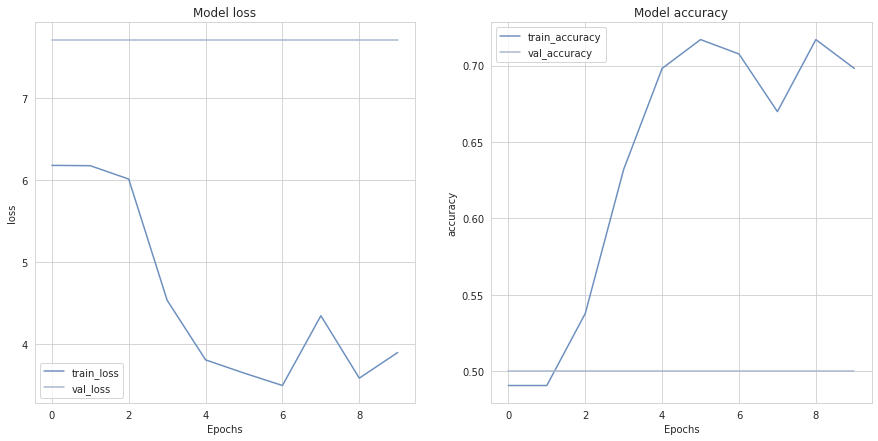

In [576]:
plt.subplot(1, 2, 1)
visualize_performance(history.history, 'loss')

plt.subplot(1, 2, 2)
visualize_performance(history.history, metric[0])

In [577]:
pred_proba = LSTM_model.predict(X_test)
pred = (pred_proba>0.5).astype('int32')

In [578]:
print(classification_report(y_test.reshape(-1, 1), pred))

              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        50
         1.0       0.00      0.00      0.00        54

    accuracy                           0.48       104
   macro avg       0.24      0.50      0.32       104
weighted avg       0.23      0.48      0.31       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


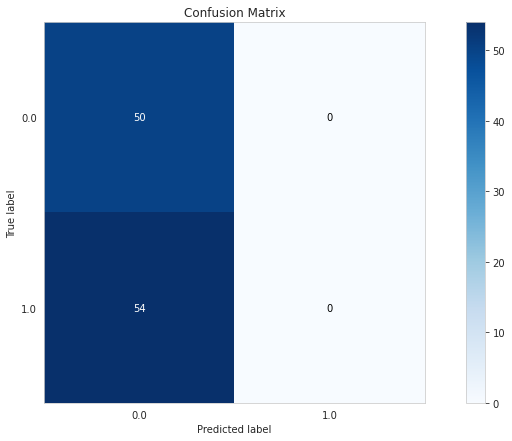

In [579]:
scikitplot.metrics.plot_confusion_matrix(y_test, pred)

#### 4.2 CNN-LSTM Network Model - TensorFlow

In [580]:
from keras.layers import TimeDistributed, Conv1D

Input shape of CNN - LSTM Model
> `(n_row, n_steps, n_length, n_features)`

In [581]:
timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_steps, seq_len = 1, X_train.shape[1]

X_train = X_train.reshape((X_train.shape[0], n_steps, seq_len, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, seq_len, n_features))

In [582]:
CNN_LSTM = keras.Sequential([
                             TimeDistributed(Conv1D(512, 2, activation='relu', input_shape=(None, seq_len, n_features))),
                             TimeDistributed(layers.MaxPool1D(pool_size=2)),                           
                             TimeDistributed(Conv1D(128, 2, activation='relu')),
                             TimeDistributed(layers.MaxPool1D(pool_size=2)),   
                             TimeDistributed(Conv1D(64, 2, activation='relu')),
                             TimeDistributed(layers.Dropout(0.2)),

                             TimeDistributed(layers.Flatten()),
                             layers.LSTM(128, return_sequences=True),
                             layers.Dropout(0.2),
                             layers.LSTM(64),
                             layers.Dense(64, activation='relu'),
                             layers.Dense(1, activation='sigmoid')
])

In [702]:
lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = keras.losses.BinaryCrossentropy()
metric = ['accuracy']

CNN_LSTM.compile(loss=loss_fn, optimizer=optimizer, metrics=metric)

In [584]:
epochs = 20
history = CNN_LSTM.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
4/4 [==============================] - 6s 350ms/step - loss: 0.6933 - accuracy: 0.4434 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 0s 59ms/step - loss: 0.6917 - accuracy: 0.4906 - val_loss: 0.6903 - val_accuracy: 0.5673
Epoch 3/20
4/4 [==============================] - 0s 61ms/step - loss: 0.6808 - accuracy: 0.5000 - val_loss: 0.6839 - val_accuracy: 0.7115
Epoch 4/20
4/4 [==============================] - 0s 63ms/step - loss: 0.6518 - accuracy: 0.7358 - val_loss: 0.6689 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 0s 60ms/step - loss: 0.5731 - accuracy: 0.8302 - val_loss: 0.6306 - val_accuracy: 0.6731
Epoch 6/20
4/4 [==============================] - 0s 59ms/step - loss: 0.5091 - accuracy: 0.7547 - val_loss: 0.7441 - val_accuracy: 0.5288
Epoch 7/20
4/4 [==============================] - 0s 62ms/step - loss: 0.4292 - accuracy: 0.8208 - val_loss: 0.7051 - val_accuracy: 0.6058
Epoch 8/20
4/4 [==========

In [585]:
CNN_LSTM.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, 1, 59, 512)        4608      
_________________________________________________________________
time_distributed_97 (TimeDis (None, 1, 29, 512)        0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 1, 28, 128)        131200    
_________________________________________________________________
time_distributed_99 (TimeDis (None, 1, 14, 128)        0         
_________________________________________________________________
time_distributed_100 (TimeDi (None, 1, 13, 64)         16448     
_________________________________________________________________
time_distributed_101 (TimeDi (None, 1, 13, 64)         0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 1, 832)          

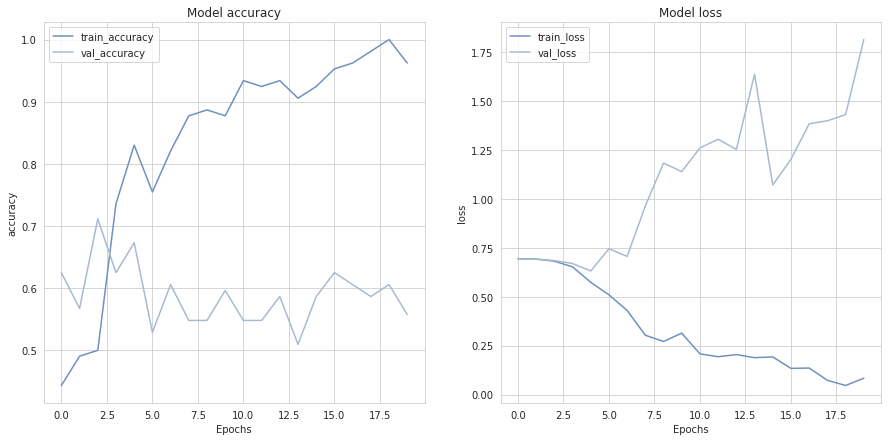

In [586]:
plt.subplot(1, 2, 1)
visualize_performance(history.history, 'accuracy')
plt.subplot(1, 2, 2)
visualize_performance(history.history, 'loss')

#### 4.3 LSTM Neural Network Model - PyTorch

In [587]:
! pip install torch --quiet

In [622]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [675]:
class TorchLSTM_Model(nn.Module):
  def __init__(self, n_feature, n_hidden, n_layers):
    super().__init__()

    self.lstm_layer = nn.LSTM(
        input_size=n_feature,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first=True,
        dropout=0.7
    )

    self.classication_layer = nn.Sequential(
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Linear(n_hidden, 1),
        nn.Sigmoid()
    )

  def forward(self, X):
    self.lstm_layer.flatten_parameters()
    # output batch_size, seq_len, hidden_size
    _, (hidden, _) = self.lstm_layer(X)
    return self.classication_layer(hidden[-1])

In [677]:
def fit(dataloader, model, loss_fn, optim, lr_scheduler):
  data_size = len(dataloader.dataset)
  n_batch = len(dataloader)
  total_loss, accuracy = 0, 0
  lrs = []

  for batch, (X, y) in enumerate(dataloader):
    pred = model(X.float())

    optim.zero_grad()
    loss = loss_fn(pred.squeeze(1), y)
    loss.backward()
    optim.step()
    
    lrs.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()

    total_loss += loss.item()
    accuracy += ((pred.squeeze(1) > 0.5) == y).sum().float().item()

    if batch % 10 == 0:
      print(f"Train Loss: {loss:.3f}  [{(batch+1)*data_size}/{data_size*n_batch}]")
  
  avg_loss = total_loss / n_batch
  accuracy_ = accuracy / data_size * 100

  return avg_loss, accuracy, lrs

In [678]:
def valid(dataloader, model, loss_function):
  data_size = len(dataloader.dataset)
  n_batch = len(dataloader)
  total_loss, accuracy = 0, 0

  with torch.no_grad(): 
    for batch, (X, y) in enumerate(dataloader):
      pred = model(X.float())
      total_loss += loss_function(pred.squeeze(1), y).item()
      # compute number of correct answer
      accuracy += ((pred.squeeze(1) > 0.5) == y).sum().float().item()
        
  avg_loss = total_loss / n_batch
  accuracy = accuracy / data_size * 100 

  print(f'Accuracy: {accuracy:.2f}%, Average Loss: {avg_loss:.3f} \n')    
  return avg_loss, accuracy

In [679]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

LSTM_torch = TorchLSTM_Model(X_train.shape[2], 256, 3).to(device)

train_dataloader = DataLoader([[X_train[i], y_train[i]] for i in range(len(X_train))])
val_dataloader = DataLoader([[X_val[i], y_val[i]] for i in range(len(X_val))])

epochs = 12
max_lr = 1e-3
optimizer = torch.optim.Adam(LSTM_torch.parameters(), lr=max_lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(X_train))
loss_function = nn.BCELoss()

history = {'val_loss' : [], 'val_accuracy': [], 'loss': [], 'accuracy': []}

In [680]:
for epoch in range(epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  train_loss, train_acc, lrs = fit(train_dataloader, LSTM_torch, loss_function, optimizer, lr_scheduler)
  val_loss, val_acc = valid(val_dataloader, LSTM_torch, loss_function)
  history['val_loss'].append(val_loss)
  history['val_accuracy'].append(val_loss)
  history['loss'].append(train_loss)
  history['accuracy'].append(train_acc)
  history['lrs'] = lrs

Epoch 1
-------------------------------
Train Loss: 0.673  [106/11236]
Train Loss: 0.663  [1166/11236]
Train Loss: 0.652  [2226/11236]
Train Loss: 0.745  [3286/11236]
Train Loss: 0.744  [4346/11236]
Train Loss: 0.735  [5406/11236]
Train Loss: 0.725  [6466/11236]
Train Loss: 0.677  [7526/11236]
Train Loss: 0.678  [8586/11236]
Train Loss: 0.668  [9646/11236]
Train Loss: 0.725  [10706/11236]
Accuracy: 50.00%, Average Loss: 0.693 

Epoch 2
-------------------------------
Train Loss: 0.667  [106/11236]
Train Loss: 0.666  [1166/11236]
Train Loss: 0.651  [2226/11236]
Train Loss: 0.764  [3286/11236]
Train Loss: 0.741  [4346/11236]
Train Loss: 0.704  [5406/11236]
Train Loss: 0.184  [6466/11236]
Train Loss: 3.606  [7526/11236]
Train Loss: 0.720  [8586/11236]
Train Loss: 0.443  [9646/11236]
Train Loss: 0.939  [10706/11236]
Accuracy: 50.00%, Average Loss: 0.694 

Epoch 3
-------------------------------
Train Loss: 0.663  [106/11236]
Train Loss: 0.657  [1166/11236]
Train Loss: 0.512  [2226/11236]
T

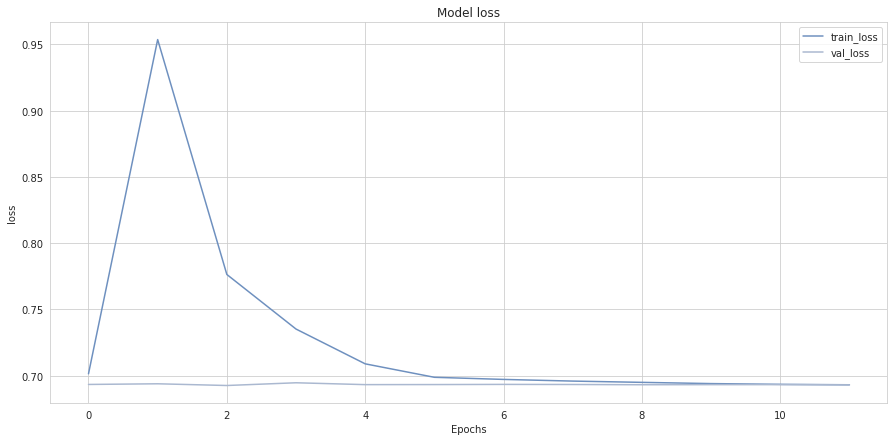

In [685]:
visualize_performance(history, 'loss')

#### 5. Making Prediction on Test Dataset

#### 5.1 LSTM 

In [733]:
probs = LSTM_model.predict(X_test) 
pred = (probs > 0.5).astype(np.float32)
print(classification_report(y_test.reshape(-1, 1), pred))

              precision    recall  f1-score   support

         0.0       0.81      0.42      0.55        50
         1.0       0.63      0.91      0.74        54

    accuracy                           0.67       104
   macro avg       0.72      0.66      0.65       104
weighted avg       0.71      0.67      0.65       104



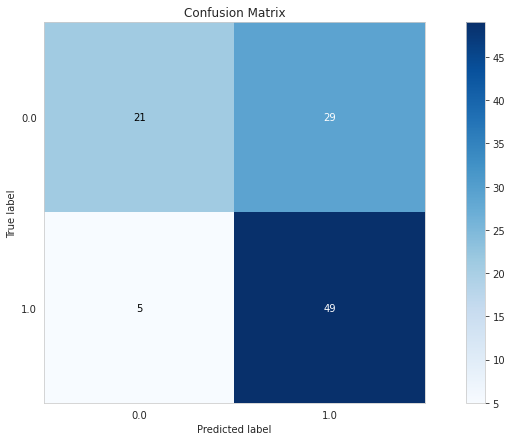

In [732]:
scikitplot.metrics.plot_confusion_matrix(y_test, pred)

#### 5.2 Pytorch LSTM

In [736]:
test_dataloader = DataLoader([[X_test[i], y_test[i]] for i in range(len(X_test))])
accuracy, loss = valid(test_dataloader, LSTM_torch, loss_function)

Accuracy: 48.08%, Average Loss: 0.693 



#### 5.3 CNN - LSTM

Reshape test_data to correct input shape

In [739]:
X_test = X_test.reshape((X_test.shape[0], n_steps, seq_len, n_features))

In [742]:
probs = CNN_LSTM.predict(X_test)
pred = (probs > 0.5).astype(np.float32)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.66      0.84      0.74        50
         1.0       0.80      0.59      0.68        54

    accuracy                           0.71       104
   macro avg       0.73      0.72      0.71       104
weighted avg       0.73      0.71      0.71       104



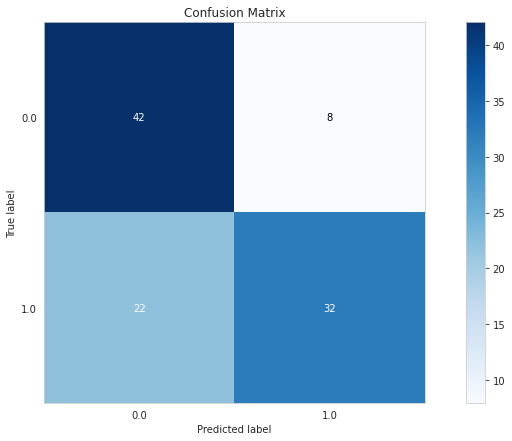

In [743]:
scikitplot.metrics.plot_confusion_matrix(y_test, pred)

### Reference

In [744]:
# https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
# https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification/comments#Defining-simple-model-in-keras
# https://www.analyticsvidhya.com/blog/2021/06/binary-image-classifier-using-pytorch/
# https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
# https://youtu.be/PCgrgHgy26c
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch
# https://github.com/Arturus/kaggle-web-traffic/blob/master/model.py